In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse_score

import mxnet as mx
import mxnet.gluon as gluon

from model import LSTMExogModel, Decoder, Encoder
import utils
import train

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
n = 5000
x = np.linspace(-50, 50, n)
X = x[:, np.newaxis]
noise = 0.1 * np.random.normal(0, 1, x.shape[0])

idx = np.sort(np.random.choice(np.arange(n), 1, replace=False))
bin_exog = np.zeros(n)
switch = True
for a, b in zip(idx, np.roll(idx, -1)):
    bin_exog[a:b] = int(switch)
    switch = not switch

y = np.sin(10 * np.pi * x) + noise + bin_exog * 5

start = pd.to_datetime("2018-03-11")
ts_index = pd.DatetimeIndex(start=start, end=start + pd.Timedelta(x.shape[0] - 1, 'd'), freq='1d')
ts = pd.DataFrame(y[:, np.newaxis], columns=['ts'], index=ts_index)

In [289]:
train_ratio = 0.7
split_point = int(ts.shape[0] * train_ratio)
ts_train = ts[:split_point]
ts_test = ts[split_point:]
exog_train = bin_exog[:, np.newaxis][:split_point]
exog_test = bin_exog[:, np.newaxis][split_point:]
ts_train = ts_train.assign(exog1=bin_exog[:split_point])
ts_test = ts_test.assign(exog1=bin_exog[split_point:])

<IPython.core.display.Javascript object>


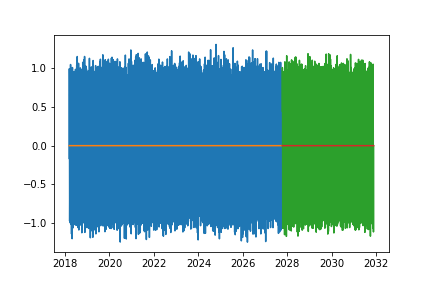

In [290]:
fig, ax = plt.subplots()
ax.plot(ts_train)
ax.plot(ts_test)

In [226]:
class SequenceDataset(gluon.data.Dataset):
    
    def __init__(self, endog, in_seq_len, exog=None, out_seq_len=1):
        self.endog = endog
        self.exog = exog
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
    
    def __getitem__(self, idx):
        data = self.endog[idx:idx + self.in_seq_len]
        label = self.endog[idx + self.in_seq_len:idx + self.in_seq_len + self.out_seq_len]
        if self.exog is not None:
            exog = self.exog[idx + self.in_seq_len:idx + self.in_seq_len + self.out_seq_len]
        else:
            exog = mx.nd.empty((self.out_seq_len, 1))
        return data, exog, label
    
    def __len__(self):
        return self.endog.shape[0] - self.in_seq_len - self.out_seq_len

In [363]:
batch_size = 64
input_seq_len = 50  # experiment with this number!!
output_seq_len = 50
num_layers = 1
feature_dim = 1
hidden_size = 256
learning_rate = 0.0001
num_epochs = 10

encoder = Encoder(hidden_size, num_layers=1, dropout=0.4)
decoder = Decoder(hidden_size, num_layers=1, output_dim=1, dropout=0.4)

encoder.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
decoder.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

datasets = {'train': SequenceDataset(mx.nd.array(ts_train[['ts']].values), input_seq_len, 
                                     exog=mx.nd.array(ts_train[['exog1']].values), out_seq_len=output_seq_len),
            'valid': SequenceDataset(mx.nd.array(ts_test[['ts']].values), input_seq_len, 
                                     exog=mx.nd.array(ts_test[['exog1']].values), out_seq_len=output_seq_len)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard', shuffle=True),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard', shuffle=True)}

opt_params = {'learning_rate': learning_rate}
train.train_seq2seq(num_epochs, encoder, decoder, loaders['train'], print_every=1, opt='adam',
                    opt_params=opt_params, teacher_forcing_prob=0.5)

[1/10] Avg. loss per epoch: 10.896
[2/10] Avg. loss per epoch: 14.718
[3/10] Avg. loss per epoch: 9.242
[4/10] Avg. loss per epoch: 6.423
[5/10] Avg. loss per epoch: 8.131
[6/10] Avg. loss per epoch: 4.738
[7/10] Avg. loss per epoch: 4.306
[8/10] Avg. loss per epoch: 1.541
[9/10] Avg. loss per epoch: 0.853
[10/10] Avg. loss per epoch: 0.734


In [326]:
gluon.rnn.LSTM?

In [359]:
opt_params = {'learning_rate': 0.0001}
train.train_seq2seq(5, encoder, decoder, loaders['train'], print_every=1, opt='adam',
                    opt_params=opt_params, teacher_forcing_prob=0.5)

[1/5] Avg. loss per epoch: 16.200
[2/5] Avg. loss per epoch: 10.057
[3/5] Avg. loss per epoch: 9.240
[4/5] Avg. loss per epoch: 8.684
[5/5] Avg. loss per epoch: 12.658


In [364]:
a, b, c = next(iter(loaders['train']))

In [365]:
enc_hidden = encoder.begin_state(batch_size=batch_size)
enc_out, dec_hidden = encoder.forward(a, enc_hidden)
dec_begin = decoder.start_sequence(sos=0., feature_dim=feature_dim, batch_size=batch_size)
preds = decoder.predict(dec_begin, dec_hidden, exog=b, nsteps=output_seq_len)

<IPython.core.display.Javascript object>


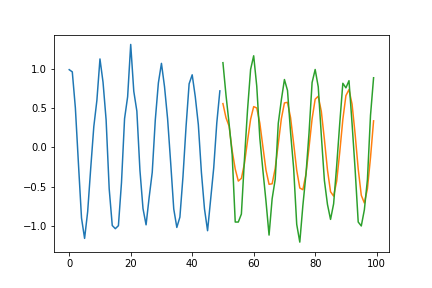

In [377]:
idx = np.random.randint(60)
input_len = a.shape[1]
output_len = c.shape[1]
fig, ax = plt.subplots()
ax.plot(np.arange(input_len), a.asnumpy()[idx])
ax.plot(np.arange(input_len, input_len + output_len), preds.asnumpy()[idx])
ax.plot(np.arange(input_len, input_len + output_len), c.asnumpy()[idx])

In [313]:
p = decoder.collect_params()

In [252]:
p

decoder15_ (
  Parameter lstm31_l0_i2h_weight (shape=(128, 1), dtype=<class 'numpy.float32'>)
  Parameter lstm31_l0_h2h_weight (shape=(128, 32), dtype=<class 'numpy.float32'>)
  Parameter lstm31_l0_i2h_bias (shape=(128,), dtype=<class 'numpy.float32'>)
  Parameter lstm31_l0_h2h_bias (shape=(128,), dtype=<class 'numpy.float32'>)
  Parameter dense15_weight (shape=(1, 33), dtype=<class 'numpy.float32'>)
  Parameter dense15_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm3_gamma (shape=(33,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm3_beta (shape=(33,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm3_running_mean (shape=(33,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm3_running_var (shape=(33,), dtype=<class 'numpy.float32'>)
)

In [255]:
p['dense15_bias'].data()


[ 0.17281646]
<NDArray 1 @cpu(0)>

In [7]:
lr = 0.001
enc_params = encoder.collect_params()
dec_params = decoder.collect_params()
enc_params.initialize(mx.init.Xavier(), ctx=mx.cpu())
dec_params.initialize(mx.init.Xavier(), ctx=mx.cpu())

enc_params.setattr('grad_req', 'add')
dec_params.setattr('grad_req', 'add')

enc_trainer = gluon.Trainer(encoder.collect_params(), 'adam', {'learning_rate': lr})
dec_trainer = gluon.Trainer(decoder.collect_params(), 'adam', {'learning_rate': lr})
criterion = gluon.loss.L2Loss()

In [8]:
inp, exog, outp = next(iter(loaders['train']))
# train_batch(inp, outp, teacher_forcing_prob=0.0)

In [9]:
batch_size, output_seq_len, output_dim = outp.shape
enc_hidden = encoder.begin_state(batch_size=batch_size)

encoder.collect_params().zero_grad()
decoder.collect_params().zero_grad()

losses = []
batch_loss = 0.0


In [10]:
with mx.autograd.record():
    loss = mx.nd.zeros((1,))
    enc_out, dec_hidden = encoder.forward(inp.transpose((2, 0, 1)), enc_hidden)
    dec_inp = mx.nd.zeros(batch_size * output_dim * 1).reshape((output_dim, batch_size, 1))

    use_teacher_forcing = np.random.random() < 1.0
    if use_teacher_forcing:
        for di in range(output_seq_len):
            dec_out, dec_hidden = decoder.forward(dec_inp, dec_hidden)
            L = criterion(dec_out, outp[:, di, :].reshape((batch_size, -1)))

            # target is (batch_size, out_seq_len, feature_dim)
            dec_inp = outp[:, di:di+1, :].transpose((2, 0, 1))
#                 print(dec_inp.shape)
            losses.append(L)
            loss = mx.nd.add(loss, L)
    loss.backward()
#             L.backward(retain_graph=True)
#     for loss in losses:
#         loss.backward(retain_graph=True)
#         print('asdf')
#         batch_loss += mx.nd.sum(loss).asscalar()

In [58]:
c.shape

(128, 50, 1)

In [19]:
with mx.autograd.record():
    for loss in losses:
        loss.backward(retain_graph=True)
        print('asdf')
        batch_loss += mx.nd.sum(loss).asscalar()

MXNetError: [18:08:17] src/imperative/imperative.cc:372: Check failed: !AGInfo::IsNone(*i) Cannot differentiate node because it is not in a computational graph. You need to set is_recording to true or use autograd.record() to save computational graphs for backward. If you want to differentiate the same graph twice, you need to pass retain_graph=True to backward.

Stack trace returned 6 entries:
[bt] (0) 0   libmxnet.so                         0x0000001c0e0692cf libmxnet.so + 58063
[bt] (1) 1   libmxnet.so                         0x0000001c0e06906f libmxnet.so + 57455
[bt] (2) 2   libmxnet.so                         0x0000001c0f07b987 MXNDListFree + 467367
[bt] (3) 3   libmxnet.so                         0x0000001c0eff3dcd MXAutogradBackwardEx + 893
[bt] (4) 4   libffi.6.dylib                      0x0000000107a35884 ffi_call_unix64 + 76
[bt] (5) 5   ???                                 0x00007fff5a00b170 0x0 + 140734703382896



In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0
    total_samples = 0
    enc_hidden = encoder.begin_state(batch_size=batch_size)
    for data, exog, target in loaders['train']:
        # assert data.shape == (batch_size, input_seq_len, feature_dim)
        exog_dim = exog.shape[2]
        assert exog.shape == (batch_size, 1, exog_dim)
        data = data.transpose((2, 0, 1))
        hidden = detach(hidden)
        with mx.autograd.record():
            output = model.forward(data, hidden, exog=exog.reshape((batch_size, exog_dim)))
            L = loss(output, target.reshape((batch_size, -1)))
            L.backward()
        trainer.step(batch_size)
        total_loss += mx.nd.sum(L).asscalar()
        total_samples += target.shape[0]

    test_loss = 0.0
    test_samples = 0
    for data, exog, target in loaders['valid']:
        exog_dim = exog.shape[2]
        data = data.transpose((2, 0, 1))
        output = model.forward(data, hidden, exog=exog.reshape((batch_size, exog_dim)))
        L = loss(output, target.reshape((batch_size, -1)))
        test_loss += mx.nd.sum(L).asscalar()
        test_samples += target.shape[0]
    maybe_print_summary(epoch, log_interval, total_loss, total_samples)
    maybe_print_summary(epoch, log_interval, test_loss, test_samples, label='valid')